In [9]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import to_categorical, Sequence
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import FastText, Doc2Vec

In [3]:
class_mapping = {}
with open('../dbpedia_csv/classes.txt') as txt_file:
    line_num = 1
    for line in txt_file:
        class_mapping[line_num] = line.strip()
        line_num+=1
        
print(class_mapping)

{1: 'Company', 2: 'EducationalInstitution', 3: 'Artist', 4: 'Athlete', 5: 'OfficeHolder', 6: 'MeanOfTransportation', 7: 'Building', 8: 'NaturalPlace', 9: 'Village', 10: 'Animal', 11: 'Plant', 12: 'Album', 13: 'Film', 14: 'WrittenWork'}


### Define Data Generator

In [ ]:
class Doc2Vec_FastText_SequenceDataGenerator(Sequence):
    def __init__(self, list_IDs, batch_size=32,
                 n_classes=14, shuffle=True):
        'Initialization'
        self.dim = (300,)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate index of the batch
        indexes = self.indexes[index:(index+1)]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        
        FT_array = np.empty((self.batch_size, *self.dim))
        DV_array = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype = int)
        for item in list_IDs_temp:
            Xarray = pkl.load(open('dbpedia/Training/'+item, 'rb'))
        for i, row in enumerate(Xarray[1]):
            try:
                FT_array[i,] = fastText.wv[row[-1]]
            except KeyError:
                # KeyError is raised when row[-1] is not in the FastText vocabulary
                FT_array[i,] = np.zeros((300,))
            DV_array[i,] = Doc2Vec_model.infer_vector(row)
            y[i] = Xarray[0]-1

        return [FT_array,DV_array], to_categorical(y, num_classes=self.n_classes)

### Load FastText and Doc2Vec embeddings

In [ ]:
fastText = FastText.load_fasttext_format('fasttext.bin')

Doc2Vec_model = Doc2Vec.load("Doc2Vec.model")
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

partition, labels = pkl.load(open('dbpedia/Training/Metadata', 'rb'))
for key in labels.keys():
    labels[key] -= 1

In [ ]:
params = {'batch_size':32, 'n_classes': 14, 'shuffle': True}
training_generator = Doc2Vec_FastText_SequenceDataGenerator(partition['train'], **params)
validation_generator = Doc2Vec_FastText_SequenceDataGenerator(partition['validation'], **params)

### Define the Doc2Vec_FastText model

In [ ]:
fastText_input = Input(shape = (300,), name = 'fastText_input')
fastText_output = Dense(32, activation = 'relu')(fastText_input)
Doc2Vec_input = Input(shape = (300,), name = 'Doc2Vec_input')
Doc2Vec_dense = Dense(128, activation = 'relu')(Doc2Vec_input)
Doc2Vec_output = Dense(128, activation = 'relu')(Doc2Vec_dense)
concatenated = keras.layers.concatenate([fastText_output, Doc2Vec_output])
predictions = Dense(14, activation = 'softmax')(concatenated)

model = Model(inputs = [fastText_input, Doc2Vec_input], outputs = predictions)
model.compile(optimizer ='Nadam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.name = 'Doc2Vec_FastText'
loss_acc_path = model.name+'loss_acc'

### Training

In [ ]:
history = model.fit_generator(generator = training_generator, epochs = 5, validation_data = validation_generator, verbose = 1)
loss_acc = {}
if os.path.exists(loss_acc_path):
    loss_acc = pkl.load(open(loss_acc_path, 'rb'))
    loss_acc['acc'] = loss_acc['acc'] + history.history['acc']
    loss_acc['loss'] = loss_acc['loss'] + history.history['loss']
else:
    loss_acc['acc'] = history.history['acc']
    loss_acc['loss'] = history.history['loss']
pkl.dump(loss_acc,open(loss_acc_path, 'wb'))
model.save(model.name+'.hdf5')

### Testing

In [ ]:
model = keras.models.load_model('Doc2Vec_FastText.hdf5')
fastText = FastText.load_fasttext_format('fasttext.bin')
Doc2Vec_model = Doc2Vec.load('Doc2Vec.model')
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
start = time.time()
accuracies = {}
for label in os.listdir('dbpedia/Testing'):
    accuracies[label] = {}
    for sent_len in os.listdir('dbpedia/Testing/{}/'.format(label)):
        if int(sent_len) < 100:
            X_FT = np.empty((0,300))
            X_DV = np.empty((0,300))
            labels = []
            for file in os.listdir('dbpedia/Testing/{}/{}/'.format(label,sent_len)):
                sample = pkl.load(open('dbpedia/Testing/{}/{}/{}'.format(label,sent_len,file), 'rb'))
                labels.append(sample[0])
                try:
                    X_FT = np.vstack((X_FT,fastText.wv[sample[1][-1]]))
                except KeyError:
                    X_FT = np.vstack((X_FT,np.zeros((300,))))
                X_DV = np.vstack((X_DV, Doc2Vec_model.infer_vector(sample[1])))
            result = model.predict([X_FT,X_DV])
            result = np.argmax(result,axis = 1)+1
            accuracy = np.sum(result == labels)/len(labels)
            print('{}, sentence length: {}, Accuracy: {}'.format(label,sent_len,np.sum(result == labels)/len(labels)))
            accuracies[label][sent_len] = accuracy
            print('elapsed time: {}'.format((time.time()-start)/60))
    pkl.dump(accuracies, open('dbpedia/Doc2Vec_FastText_Accuracy', 'wb'))

In [4]:
accs = pkl.load(open('Doc2Vec_FastText_Accuracy', 'rb'))

In [7]:
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns), key = int), axis = 1).transpose()
accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)

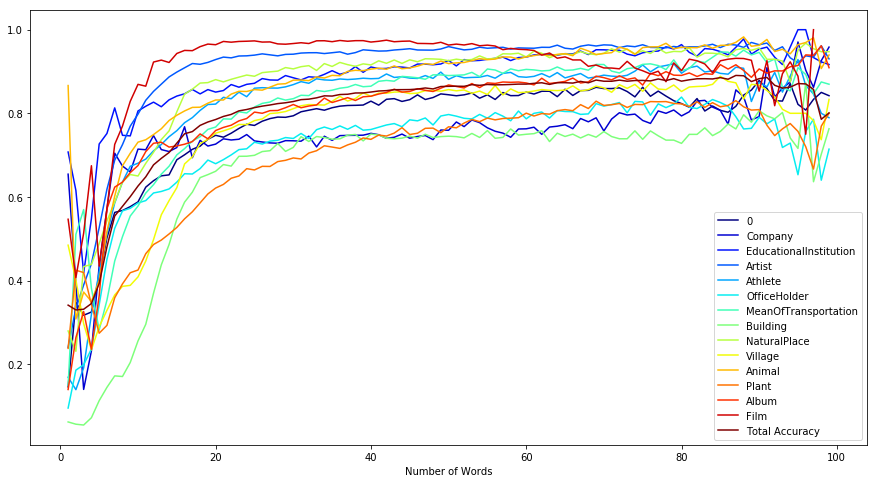

In [10]:
accuracies.plot(x ='Number of Words', figsize = (15,8), colormap = 'jet')
plt.show()

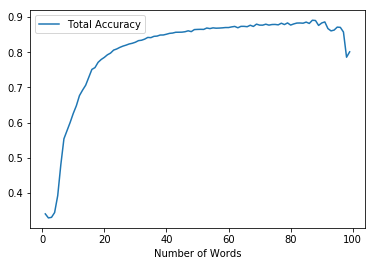

In [11]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy')
plt.show()